In [1]:
import polars as pl
import pandas as pd
from random import sample
from statistics import mean
from functools import reduce
import multiprocessing as mp
from collections import Counter
from collections import defaultdict

from tqdm import tqdm
import matplotlib.pyplot as plt

from tools.utils.parallel import chunks
from tools.utils.datalake import SimpleDataLakeHelper
from tools.utils.misc import table_rows_to_columns, table_to_tokens
from tools.utils.metrics import recall_at_k, ndcg_at_k

In [2]:
analyses_dir = '/data4/nanni/tesi-magistrale/experiments/multi_key_join/wikiturlsnap_mate'

# Time Analyses

In [172]:
multi_keys = [
    'party-district',
    'party-member', 
    'director-genre'
]
multi_key = multi_keys[2]

T = 0.9
N = 600
K = 50

josie_mc = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{T}/results_multi_josie.csv')
josie_bl = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{T}/results_single_josie.csv')
mate = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{T}/mate_time.txt', has_header=False, separator=';').rename({'column_1': 'duration'})
multi_key

'director-genre'

In [173]:
josie_bl.select(['query_id', 'duration',  'num_set_read', 'num_list_read', 'max_set_size_read', 'max_list_size_read']) \
    .group_by('query_id').sum().drop('query_id').with_columns(pl.col('duration') / 1000).describe()

statistic,duration,num_set_read,num_list_read,max_set_size_read,max_list_size_read
str,f64,f64,f64,f64,f64
"""count""",600.0,600.0,600.0,600.0,600.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",0.072365,23.916667,58.07,189.653333,17115.441667
"""std""",0.037173,49.150714,56.042839,428.509713,7397.9414
"""min""",0.002,0.0,7.0,0.0,288.0
"""25%""",0.048,0.0,28.0,0.0,7129.0
"""50%""",0.068,2.0,48.0,55.0,21579.0
"""75%""",0.092,24.0,70.0,172.0,21579.0
"""max""",0.34,410.0,555.0,4213.0,38152.0


In [174]:
josie_mc.select(['query_id', 'duration', 'num_set_read', 'num_list_read', 'max_set_size_read', 'max_list_size_read']) \
    .group_by('query_id').sum().drop('query_id').with_columns(pl.col('duration') / 1000).describe()

statistic,duration,num_set_read,num_list_read,max_set_size_read,max_list_size_read
str,f64,f64,f64,f64,f64
"""count""",600.0,600.0,600.0,600.0,600.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",0.070137,38.668333,57.953333,249.315,13241.795
"""std""",0.035475,41.286915,55.951128,392.130633,5407.93709
"""min""",0.002,0.0,7.0,0.0,241.0
"""25%""",0.045,1.0,28.0,21.0,4903.0
"""50%""",0.067,50.0,48.0,123.0,16676.0
"""75%""",0.09,54.0,69.0,327.0,16676.0
"""max""",0.255,269.0,553.0,4067.0,19076.0


In [177]:
mate[:-1].map_rows(lambda t: (eval(t[0]),)).explode('column_0').rename({'column_0': 'duration'}).describe()

statistic,duration
str,f64
"""count""",600.0
"""null_count""",0.0
"""mean""",60.475185
"""std""",51.368929
"""min""",7.056
"""25%""",27.565
"""50%""",47.833
"""75%""",77.5
"""max""",442.531


# Other Analyses

## How many results are returned by BSL and MC? And how many results of BSL are included by those from MC? 

In [228]:
multi_keys = [
    'party-district',
    'party-member', 
    # 'director-genre',
    # 'home-road'
]

N = 600
K = 50
min_h = 0.6
k_values = [1, 5, 10, 20, 30]

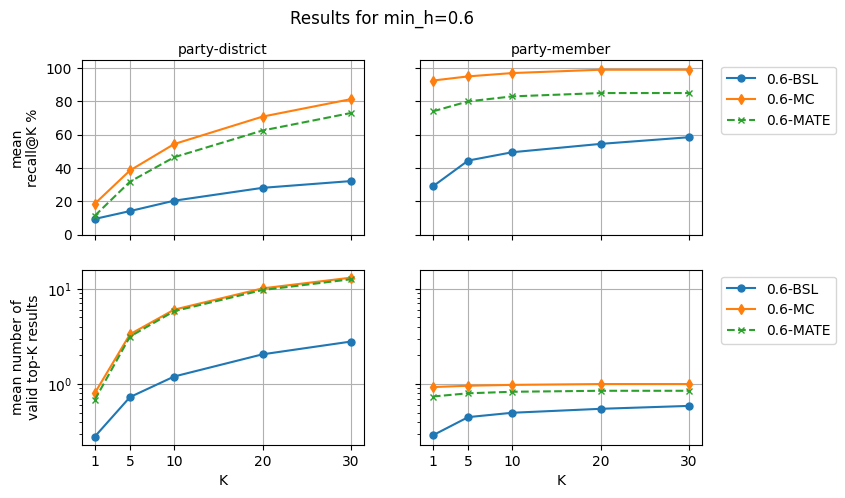

In [229]:
# fig, (axs_rec, axs_ndcg, axs_num_res) = plt.subplots(3, len(multi_keys), sharey='row', sharex='col', figsize=(4 * len(multi_keys), 5))
fig, (axs_rec, axs_num_res) = plt.subplots(2, len(multi_keys), sharey='row', sharex='col', figsize=(4 * len(multi_keys), 5))

plt.subplots_adjust(hspace=0.2)

versions = ['BSL', 'MC', 'MATE']
data = defaultdict(dict)

line_color = {
    'BSL': {
        'line': '-o',
        'color': 'tab:blue'
    },
    'MC': {
        'line': '-d', 
        'color': 'tab:orange'
    },
    'MATE': {
        'line': '--x', 
        'color': 'tab:green'
    }
}

actually_used_query_ids = defaultdict(list)
for multi_key, axrec, axnr in zip(multi_keys, axs_rec, axs_num_res):
    results = (
            pl
            .read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/final_results.csv')
            .filter(pl.col('version').is_in(versions))
            .with_columns(
                (pl.col('columns_overlap') > 0).cast(pl.Int8).alias('columns_overlap_01'),
                pl.col('columns_overlap').replace(-2, 0)
            )
        )
    
    # take only those queries that have at least one accepted candidate
    # from these, select only the first 100
    nresults = 100
    analyses_results = [
        q for (q, ), group in results.group_by('query_id') 
        if any(group.select('columns_overlap').filter(pl.col('columns_overlap') > 0).rows())]
    analyses_results = sample(analyses_results, min(nresults, len(analyses_results)))
    results = results.filter(pl.col('query_id').is_in(analyses_results))

    if len(analyses_results) < nresults:
        print(f'min_h={min_h} - {multi_key} has not {nresults} results: {len(analyses_results)}')
    
    for q in analyses_results:
        actually_used_query_ids[multi_key].append(q)

    # compute the cumulative number of total valid results for both BSL and MC
    # and the % of BSL results that is a subset of the MC results (--> this btw doens't tell much about
    # values that BSL only discovered) and compute the recall@K (0/1 values with meaning "not valid/valid candidate")
    num_results_per_k = []
    silver_standard = {'01': {}, 'relevance': {}}

    for version in versions:
        data[version]['final_recall'] = {}
        data[version]['final_ndcg'] = {}
        data[version]['final_mean_nres'] = {}
        
        data[version]['results_for_query'] = {}
        data[version]['results_for_query_01'] = {}
        data[version]['results'] = results.filter((pl.col('version') == version))

    query_groups = results.group_by('query_id')

    # compute the silver standard, both as 0/1 values (not-valid/valid)
    # and relevance values (the overlap between the query columns and the result table)
    for (q, ), qgroup in query_groups:
        silver_standard['relevance'][q], silver_standard['01'][q] = zip(
            *results
            .filter(pl.col('query_id') == q)
            .unique(subset=['query_id', 'result_id'])
            .select(['columns_overlap', 'columns_overlap_01'])
            .sort(by='columns_overlap', descending=True)
            .rows())
    
    # for each version and query extract as a list the results, both as 0/1 values and relevance values
    for (version, q), qgroup in results.group_by('version', 'query_id'):
        data[version]['results_for_query_01'][q] = qgroup.select('columns_overlap_01').to_series().to_list()
        data[version]['results_for_query'][q] = qgroup.select('columns_overlap').to_series().to_list()
    
    # for each K, compute recall@K, nDCG@K 
    # and the mean number of results found per query
    for k in k_values:
        for version in versions:
            data[version]['recall'] = []
            data[version]['ndcg'] = []
            data[version]['mean_nres'] = []

        for (q, ), qgroup in query_groups:
            for version in versions:
                r = data[version]['results_for_query_01'][q] if q in data[version]['results_for_query_01'] else []
                data[version]['mean_nres'].append(sum(r[:k]))
                data[version]['recall'].append(recall_at_k(silver_standard['01'][q], r, k))
                
                r = data[version]['results_for_query'][q] if q in data[version]['results_for_query'] else []
                data[version]['ndcg'].append(ndcg_at_k(silver_standard['relevance'][q], r, k)[0])

        for version in versions:
            data[version]['final_recall'][k] =      100 * mean(data[version]['recall'])
            data[version]['final_ndcg'][k] =        100 * mean(data[version]['ndcg'])
            data[version]['final_mean_nres'][k] =   mean(data[version]['mean_nres'])

    for i, version in enumerate(versions):
        axrec.plot(k_values, list(data[version]['final_recall'].values()),      line_color[version]['line'], label=f'{min_h}-{version}', markersize=5)
        # axndcg.plot(k_values, list(data[version]['final_ndcg'].values()),       line_color[version]['line'], label=f'{min_h}-{version}', markersize=5)
        axnr.plot(k_values, list(data[version]['final_mean_nres'].values()),    line_color[version]['line'], label=f'{min_h}-{version}', markersize=5)
    
    axrec.set_xlabel(multi_key)
    axrec.xaxis.set_label_position('top')
    axnr.set_xlabel(f"K")
    
    axrec.grid(True)
    # axndcg.grid(True)
    axnr.grid(True)

    axnr.set_xticks(k_values)
    axnr.set_yscale('log')


axs_rec[0].set_ylabel('mean\nrecall@K %')
axs_rec[0].set_ylim(0, 105)
# axs_ndcg[0].set_ylabel('mean\nnDCG@K %')
axs_num_res[0].set_ylabel('mean number of\nvalid top-K results')

axs_rec[-1].legend(loc='best',      bbox_to_anchor=(0., 0., 1.5, 1))
# axs_ndcg[-1].legend(loc='best',     bbox_to_anchor=(0., 0., 1.5, 1))
axs_num_res[-1].legend(loc='best',  bbox_to_anchor=(0., 0., 1.5, 1))
fig.suptitle(f'Results for min_h={min_h}')
fig.show()

## Is there any case where BSL find valid candidates and MC not?

In [42]:
for min_h in min_h_values:
    qids = []
    for multi_key in multi_keys:
        results = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/final_results.csv').filter(pl.col('SLOTH_columns_overlap') > 0)
        for qid, qgroup in results.group_by('query_id'):
            nres_bsl = qgroup.filter(pl.col('version') == 'baseline').shape[0]
            nres_mc  = qgroup.filter(pl.col('version') == 'MC').shape[0]
            if nres_bsl > nres_mc:
                qids.append([multi_key, qid])
    print(f'min_h = {min_h}')
    print(qids)

min_h = 0.6
[['home-road', (396269,)], ['home-road', (178448,)], ['home-road', (555382,)], ['home-road', (179220,)], ['home-div', (335320,)], ['home-div', (531762,)], ['home-div', (531891,)], ['home-div', (345132,)], ['home-div', (532106,)], ['home-div', (480864,)], ['party-district', (495363,)], ['party-district', (1381597,)], ['party-district', (1580721,)], ['party-district', (1544348,)], ['party-district', (1376179,)]]
min_h = 0.9
[['party-member', (1101205,)], ['home-road', (495894,)], ['home-road', (276314,)], ['home-road', (555382,)], ['home-road', (272552,)], ['home-road', (179220,)], ['home-road', (519247,)], ['home-road', (472474,)], ['home-road', (495718,)], ['home-div', (404655,)], ['home-div', (335419,)], ['home-div', (345143,)], ['home-div', (470306,)], ['home-div', (535887,)], ['party-district', (495363,)], ['party-district', (1544348,)]]


## How big are the attributes domains (only from queries)?

In [30]:
dlh = SimpleDataLakeHelper('mongodb', 'wikiturlsnap', 'standard')


N = 300
K = 50
T = 0.9

domains_set = defaultdict(set)
domains_bag = defaultdict(set)

for multi_key in multi_keys:
    mk_results = pl.read_csv(f"{analyses_dir}/{multi_key}/N{N}_K{K}_T{T}/final_results.csv")
    keys = multi_key.split('-')
    for qid in tqdm(mk_results.select('query_id').rows()):
        if qid[0] not in actually_used_query_ids:
            continue
        table_obj = dlh.get_table_by_numeric_id(qid[0])
        bad_columns = table_obj['numeric_columns']
        headers = [str(h).lower().strip() for h in (table_obj['headers'] if table_obj['headers'] != None else table_obj['content'][0])]
        table = table_rows_to_columns(table_obj['content'], 0, len(table_obj['content'][0]), bad_columns)

        for header, column, is_bad in zip(headers, table, bad_columns):
            if not is_bad:
                for key in keys:
                    if header == key:
                        for token in table_to_tokens([column], 'set', [0] * len(column)):
                            domains_set[key].add(token)
                        for token in table_to_tokens([column], 'bag', [0] * len(column)):
                            domains_bag[key].add(token)

  2%|▏         | 306/18800 [00:00<00:14, 1253.72it/s]

100%|██████████| 30000/30000 [00:07<00:00, 3781.93it/s]


In [31]:
data = [[k, len(domains_set[k]), len(domains_bag[k])] for k in domains_set.keys()]
pl.DataFrame(data, schema=['attribute', 'set_query_domain_size', 'bag_query_domain_size'], orient='row')

attribute,set_query_domain_size,bag_query_domain_size
str,i64,i64
"""province""",599,2214
"""city""",3506,4555
"""club""",2199,2234
"""stadium""",1417,1550
"""country""",704,1278


## How are distributed the attribute domains across all the tables?

In [68]:
def initializer(_domains_set:defaultdict):
    global domains_set
    domains_set = _domains_set


def task(data):
    global domains_set
    dlh = SimpleDataLakeHelper('mongodb', 'wikiturlsnap', 'standard')
    tobj_range = data[0]
    set_domain_freq = defaultdict(int)

    for i in tobj_range:
        tobj = dlh.get_table_by_numeric_id(i)
        tset = table_to_tokens(tobj['content'], 'set', tobj['numeric_columns'])
        
        for attr, values in domains_set.items():
            if any(x in tset for x in values):
                set_domain_freq[attr] += 1
        
    return Counter(set_domain_freq)


def update_counter(a, b):
    a.update(b)
    return a

p = 32
n = 100_000

with mp.Pool(p, initializer, (domains_set, )) as pool:
    work = sample(range(dlh.get_number_of_tables()), n)
    set_domain_freq = pool.map(task, chunks(work, len(work) // p))
    set_domain_freq = reduce(update_counter, set_domain_freq)


In [69]:
data = [[k, set_domain_freq[k], round(100 * set_domain_freq[k] / n, 1)] for k in set_domain_freq.keys()]
pl.DataFrame(data, schema=['attribute', 'set_frequency', f'set_frequency (% {n})'], orient='row')

attribute,set_frequency,set_frequency (% 100000)
str,i64,f64
"""nationality""",13966,14.0
"""name""",12266,12.3
"""genre""",8909,8.9
"""director""",10219,10.2
"""role""",6697,6.7
"""actor""",1429,1.4


## What kind of results does MATE find?

In [182]:
multi_keys = [
    'party-district',
    'party-member',
    'director-genre'
    # 'home-road', 
    # 'home-div',
]
multi_key = multi_keys[0]
N = 600
K = 50
min_h = 0.9
k = 10
results = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/final_results.csv')
josie_mc_results = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/results_multi_josie.csv')
results.select('query_id').unique().to_series().to_list()[10:15]

[2480982, 466020, 1533803, 391311, 2534475]

In [180]:
g = results.filter(pl.col('query_id') == 1192740)

silver_standard = g.filter(pl.col('columns_overlap') > 0).unique(subset=['query_id', 'result_id']).sort(by='columns_overlap', descending=True).select('columns_overlap').to_series().to_list()
silver_standard

[20, 20, 20, 18, 18, 18, 18]

In [183]:
x = g.filter((pl.col('version') == 'BSL') & (pl.col('columns_overlap') > 0) & (pl.col('result_rank') < k))
x

version,query_id,result_id,result_rank,columns_overlap
str,i64,i64,i64,i64


In [184]:
s = x.select('columns_overlap').to_series().to_list()
recall_at_k(silver_standard, s, k), ndcg_at_k(silver_standard, s, k)

(0, (0.0, 10))

In [185]:
x = g.filter((pl.col('version') == 'MC') & (pl.col('columns_overlap') > 0) & (pl.col('result_rank') < k))
x

version,query_id,result_id,result_rank,columns_overlap
str,i64,i64,i64,i64
"""MC""",1192740,1242201,5,20
"""MC""",1192740,1283332,8,20
"""MC""",1192740,1241729,9,20


In [186]:
s = x.select('columns_overlap').to_series().to_list()
recall_at_k(silver_standard, s, k), ndcg_at_k(silver_standard, s, k)

(0.42857142857142855, (0.6110556144795365, 10))

In [187]:
x = g.filter((pl.col('version') == 'MATE') & (pl.col('columns_overlap') > 0) & (pl.col('result_rank') < k))
x

version,query_id,result_id,result_rank,columns_overlap
str,i64,i64,i64,i64
"""MATE""",1192740,1242201,0,20
"""MATE""",1192740,1283332,1,20
"""MATE""",1192740,1241729,2,20
"""MATE""",1192740,1239513,3,18
"""MATE""",1192740,1239087,4,18
"""MATE""",1192740,877805,5,18
"""MATE""",1192740,1243168,6,18


In [188]:
s = x.select('columns_overlap').to_series().to_list()
recall_at_k(silver_standard, s, k), ndcg_at_k(silver_standard, s, k)

(1.0, (1.0, 10))